

# ArviZ and Xarray

This whole notebook is interactive!

If you are reading the slides from binder, press `space` to move to the next slide.  

*or*  

Follow along by running the code yourself!

# What is ArviZ?
ArviZ is a Python package for exploratory analysis of Bayesian models.   

ArviZ includes functions for posterior analysis, data storage, sample diagnostics, model checking, and comparison.

Xarray is a critical dependency makes data orgnization and handling very easy

![ArviZ Gallery](img/ArviZGallery.png)

# The big question
Do ArviZ developers and users think Xarray is good?



# The big question
Do ArviZ developers and users like Xarray?

<center style="font-size:100px">No. We think its GREAT</center>


# TLDR: ArviZ <3 Xarray
The Xarray package's functionality 
* allows a nice ArviZ API and easily human readable code for a more efficient single user workflow
* enables data serialization, to disk, for a group collaboration and multi user workflow
* data schema consistency enabling easier API for packages such as ArviZ 

#  ArviZ + Xarray = az.InferenceData
* The central data structure to ArviZ is `az.InferenceData`. 
* It is essentially an object composed of `xr.DataSet` objects with semantically meaninful names
* Includes some additional functionality to enable Bayesian workflow

![InferenceDataStructure](img/InferenceDataStructure.png)

# But how do we know ArviZ developers and users like Xarray?

As a statistician it's bad form to answer a question without data and math.  

In preparation for this user form we ran an exhaustive survey 


# Survey Methodology
1. Find an xarray and ArviZ user, a chair, and a mirror
2. Have that user sit in the chair
    * Mirror must be exactly 6 inches away from face. See diagram on right for exact placement
3. Ask yourself "Do you like xarray? True or False"
4. Carefully record the results.
    * Repeat step 3 and 4 10 times

*Any deviation from this procedure will invalidate study

# 
![Serious Science](img/SeriousScience.jpeg)
Data Collection Diagram for reproducibility purposes

In [1]:
import xarray as xr
import numpy as np
data = xr.DataArray(np.ones((1,10), dtype=bool),
                    dims=("respondent", "response"),
                    coords={"respondent":np.arange(1), "response": np.arange(10)})
data[:, 8] = False
data

<xarray.DataArray (respondent: 1, response: 10)>
array([[ True,  True,  True,  True,  True,  True,  True,  True, False,
         True]])
Coordinates:
  * respondent  (respondent) int64 0
  * response    (response) int64 0 1 2 3 4 5 6 7 8 9

# Survey Results

In [2]:
data

<xarray.DataArray (respondent: 1, response: 10)>
array([[ True,  True,  True,  True,  True,  True,  True,  True, False,
         True]])
Coordinates:
  * respondent  (respondent) int64 0
  * response    (response) int64 0 1 2 3 4 5 6 7 8 9

and it looks like we got 9 True and 1 False!

# What can we infer about the unobservable user  preference?
* 10 data points are great and all but how do we know it wasn't just a fluke?
* Let's use statistics to make an *inference* about the unknown value, *proportion of "True i like xarray"*, from the observed data 

## What every Bayesian wants:  A well estimated posterior distribution
A posterior *distribution* describes *every* possible user preference and the relative probability of each. 

# Bayesian Model and MCMC Sampling
We can declare a probabilistic model and our sampler. This one way in which computational Bayesians estimate posterior distributions

In [3]:
import pymc3 as pm
with pm.Model() as user_model:
    # Model definition
    true_proportion = pm.Uniform("true_proportion", 0,1)
    obs = pm.Binomial("obs", p=true_proportion, n=data.shape[1], observed=data.sum())
    
    # Sampler
    inf_data = pm.sample(chains=4, tune=2000, draws=4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_proportion]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 4 seconds.


# What is happening
In Markov Chain Monte Carlo there is an algorithm that estimates posterior by taking a lot of samples. Practically speaking we get a lot of floating point numbers

In [4]:
# Credit to Colin Carroll for this video
from IPython.display import Video
Video("img/sampling.video.mp4")


# What we get
So many floating point numbers. But luckily we can use `xr.DataSet` to handily keep track of them!

In [27]:
inf_data.posterior

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 4000)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 ... 3994 3995 3996 3997 3998 3999
Data variables:
    true_proportion  (chain, draw) float64 0.9524 0.7297 0.8909 ... 0.775 0.7644
Attributes:
    created_at:                 2021-05-20T03:59:32.925812
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              3.80016827583313
    tuning_steps:               2000

# Standard Array formats make (and  plotting) easy!
ArviZ just "knows" where things are and can do the "right thing". As developers xarray makes our code simpler, for users it makes the API awesome.

<class 'xarray.core.dataset.Dataset'>


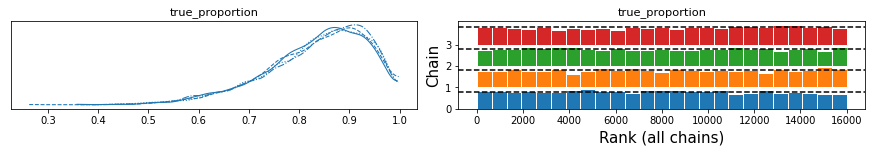

In [6]:
import arviz as az
print(type(inf_data.posterior))
az.plot_trace(inf_data, kind="rank_bars");

# And our coveted posterior plot!

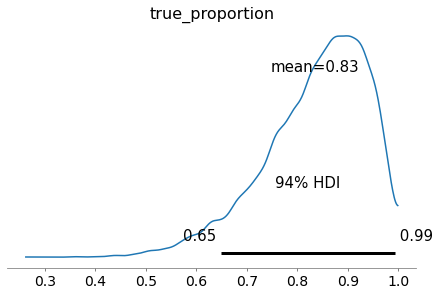

In [7]:
az.plot_posterior(inf_data);

# But posterior distributions not even all of it
Inference runs generate a lot more numbers 

In [8]:
inf_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

These numbers are useful for other purposes like diagnostics

# And inference is just one part of the workflow
There are many steps and PPLs only help out with some of them. ArviZ aims to help with the others.

![Bayesian Workflow](img/Bayesian_workflow_Updated.png)

# The answer: More Xarray Datasets!
One `az.InferenceData` group to capture every type of array a Bayesian could want

In [9]:
radon_dataset = az.load_arviz_data("radon")
radon_dataset

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

# And we can serialize InfData to disk
Xarray + InfData conforms to NetCDF4 file format specification quite conveniently

In [10]:
path = "xarray_user_forum_2021"
filename = "I_DONT_HAVE_TO_RUN_THIS_AGAIN_THIS_IS_AMAZING.nc"
inf_data.to_netcdf(filename)

'I_DONT_HAVE_TO_RUN_THIS_AGAIN_THIS_IS_AMAZING.nc'

In [11]:
loaded_inf_data = az.from_netcdf(filename)
loaded_inf_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# What was like Life before Inf Data
Random arrays in memory
* Integer index so we'd forget everything
* Incompatible formats between ppls
* Everyone did their own diagnostics
* Serializing everything to disk and sharing results was hard

# Xarray enables
* Better single user workflow by making it so nice to work with multi dimensional arrays
* Better multi user workflow by making it easy to share and store results across a team
* Unified API for plotting and diagnostics due to convenient object structure and array handling

# Where did that one `False` come from?
Sometimes API is difficult or obtuse to use in our use case  
But! xarray provides many escape hatches to other formats like numpy or dataframes so we can get what we need

In [17]:
# Getting unique count
radon_data = az.load_arviz_data("radon")
radon_data.observed_data.to_dataframe().index.unique().shape

(919,)

# What we dont doubt: How awesome the devs are
* Xarray devs have been very generous their time and expertise with ArviZ devs.
* We really appreciate their support
* Library continues to make great progress and we're thrilled to grow with it

# But what about Dask
Yep, Dask is awesome too! We've continued to integrate dask functionality to speed up diagnostic processing or for `az.InferenceData` objects that won't fit in memory.

# Additional Info
* [Inference Data](https://arviz-devs.github.io/arviz/schema/schema.html#schema)
* ArviZ docs

# Old Slides
Going to delte these soon

# So many arrays
* Prior Predictive
* Posterior
* Divergences
* Log probabilities for diagnostics
* All the above per parameter + different shapes in hierachical models

Dataframes with integrated indexing proved valuable for analysis. Bayesian data is high dimensional and shares many of the challenges. 



# InferenceData is one path
* Full specification https://arviz-devs.github.io/arviz/schema/schema.html
* Each NetCDF group stores a different quantity

![idata](https://arviz-devs.github.io/arviz/_images/InferenceDataStructure.png)


# InferenceData sneak peek
* Read local netCDF files
* Generate `InferenceData` from a PyStan fit

Also integrated from Python with [CmdStanPy](https://arviz-devs.github.io/arviz/notebooks/InferenceDataCookbook.html#From-CmdStanPy), [CmdStan](https://arviz-devs.github.io/arviz/notebooks/InferenceDataCookbook.html#From-CmdStan) and from Julia with [CmdStan.jl](https://arviz-devs.github.io/ArviZ.jl/stable/quickstart.html#Plotting-with-CmdStan.jl-outputs-1)

## Read local netCDF files

In [ ]:
import arviz as az

# Loading a precomputed .nc file from internet.
# az.from_netcdf("radon.nc") for local netcdf
idata = az.load_arviz_data("radon")
idata

In [ ]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.ic_pointwise"] = True

## Generate InferenceData from a PyStan fit


In [ ]:
# Inference Data already compatible with Stan Interfaces (Thanks Ari, Allen and Mitzi!)
import pystan
from scipy import stats
y = stats.norm(10, 1).rvs(1000)
model = """
data {int N; real y[N];} parameters {real mu; real<lower=0> sigma;}
model { mu ~ normal(0, 1); sigma ~ cauchy(0, 1); y ~ normal(mu, sigma);}
"""
stan_model = pystan.StanModel(model_code=model, extra_compile_args=['-flto'])
fit = stan_model.sampling(data={"y":y, 'N':len(y)})

In [ ]:
idata_pystan = az.from_pystan(
    posterior=fit,
    observed_data=["y"],
)
idata_pystan

# Organized data makes complex calculation easy

## Posterior exploration and diagnosis

<table style="color:#bbb">
  <tr>
    <th><span style="color:#000">posterior</span></th>
    <th><span style="color:#000">sample stats</span></th>
    <th>log likelihood</th>
    <th>posterior predictive</th>
    <th>observed data</th>
    <th>prior</th>
    <th>prior predictive</th>
  </tr>
</table>

In [ ]:
az.plot_trace(az.load_arviz_data("centered_eight"), var_names=["mu", "tau"], kind="rank_bars");

## Leave one out cross-validation (PSIS)

<table style="color:#bbb">
  <tr>
    <th>posterior</th>
    <th>sample stats</th>
    <th><span style="color:#000">log likelihood</span></th>
    <th>posterior predictive</th>
    <th>observed data</th>
    <th>prior</th>
    <th>prior predictive</th>
  </tr>
</table>

In [ ]:
az.loo(idata)

## Prior predictive checks

<table style="color:#bbb">
  <tr>
    <th>posterior</th>
    <th>sample stats</th>
    <th>log likelihood</th>
    <th>posterior predictive</th>
    <th><span style="color:#000">observed data</span></th>
    <th>prior</th>
    <th><span style="color:#000">prior predictive</span></th>
  </tr>
</table>

In [ ]:
az.plot_ppc(idata, group="prior");

## Leave one out probability integral transform 

<table style="color:#bbb">
  <tr>
    <th>posterior</th>
    <th>sample stats</th>
    <th><span style="color:#000">log likelihood</span></th>
    <th><span style="color:#000">posterior predictive</span></th>
    <th><span style="color:#000">observed data</span></th>
    <th>prior</th>
    <th>prior predictive</th>
  </tr>
</table>

In [ ]:
az.plot_loo_pit(idata, y="y");

# ArviZ and InferenceData benefits
* Consistent data representation across languages and PPLs
* Portable and persistent netCDF format
* Shareable datasets encourage reproducibility
* Allows PPL designers to focus on PPL and not on out of sampler diagnostics and plots

# InferenceData Limitations
* InferenceData is MCMC specific
* Doesn't make full Bayesian workflow reproducible, just parts of it

# Add InferenceData support to your package
* InferenceData can just be format specification. 
* You don't need to use ArviZ or Python 

![](img/ArviZ.R.png)

# We could use your help!
* Polish the `InferenceData` [schema](https://arviz-devs.github.io/arviz/schema/schema.html)
* Additional plots and diagnostics
* Code, feedback, publicly sharing models, and cool plots you've made
* Improvements such as support for sparse data structures and others

## More information

* https://arviz-devs.github.io/arviz/
* https://arviz-devs.github.io/ArviZ.jl/stable/
* https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html
* https://arviz-devs.github.io/arviz/schema/schema.html